In [2]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.append("FixedStrides")
from main import *
results_wolant = pd.read_csv('ip32_wolant_results.csv', sep=';')
results_fst = pd.read_csv('ip32_fst_results.csv', sep=';')
results_equal_dist = pd.read_csv('ip32_equal_dist_results.csv', sep=';')
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
# results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
# results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
# results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
# results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [3]:
def plot_prefix_distribution(prefixes):
    lengths = utils.get_lengths(prefixes)
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [4]:
# prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
node_counts_tokyo = utils.get_node_counts(prefixes_tokyo)

Read 576846 prefixes from file in 8.6751868724823 seconds


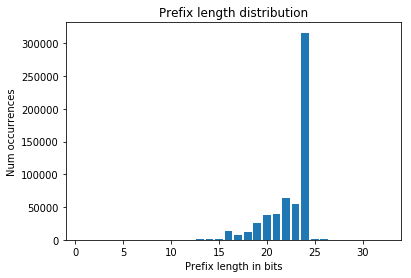

In [5]:
# plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [6]:
def append_stats(row: pd.Series, nodes: list):
    strides = row['Config'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    strides = [int(x) for x in strides]
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find])

def append_stats_to_df(df: pd.DataFrame):
    newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
    # For now assume Tokyo dataset
    newcols = df.apply(lambda row: append_stats(row, node_counts_tokyo), axis=1)
    newcols.columns = newcol_names
    return df.join(newcols)

In [9]:
results_wolant = append_stats_to_df(results_wolant)
results_fst = append_stats_to_df(results_fst)
results_equal_dist = append_stats_to_df(results_equal_dist)

In [10]:
results_wolant = results_wolant.sort_values('Match')
results_wolant[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,Percent,ChildrenMemory,ContainerStartsMemory,ContainerLengthsMemory
6,"{8, 8, 4, 2, 2, 8}",0.949728,34.448318,35.398046,21.065184,2970800,1432428.0,87.575566,463080,100144,100120
3,"{8, 8, 2, 2, 2, 2, 8}",0.981440,26.706272,27.687712,23.605024,2971824,1388596.0,84.895772,448624,107880,107852
7,"{8, 4, 4, 2, 2, 2, 2, 8}",1.161440,27.001888,28.163328,25.892960,2944456,1382388.0,84.516228,419896,108556,108524
11,"{8, 2, 2, 2, 2, 2, 2, 2, 2, 8}",1.338560,26.725887,28.064447,32.065151,2946048,1387168.0,84.808467,417608,110488,110448
2,"{8, 4, 4, 4, 4, 8}",1.659808,35.741280,37.401088,23.787359,2769680,1984000.0,121.297492,399784,31232,31208
5,"{8, 8, 4, 4, 8}",1.705152,35.556705,37.261857,18.845888,2797048,1990208.0,121.677036,428512,30556,30536
10,"{4, 5, 4, 5, 6, 4, 2, 2}",3.903232,38.639713,42.542945,26.227873,2972080,3602532.0,220.251056,633368,15632,15600
4,"{16, 8, 8}",10.658080,59.912128,70.570208,14.480928,3557360,5557760.0,339.789490,1229840,10056,10044
8,"{8, 8, 16}",10.669824,60.638752,71.308576,14.148512,2358400,53504.0,3.271119,43024,3984,3972
1,"{8, 8, 8, 8}",10.803360,60.192417,70.995777,20.843424,3338592,5545728.0,339.053880,1010712,10232,10216


In [11]:
results_fst = results_fst.sort_values('Match')
results_fst[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,Percent,ChildrenMemory,ContainerStartsMemory,ContainerLengthsMemory
3,"{18, 3, 2, 1, 8}",0.763136,46.233440,46.996576,23.667553,4206824,1626566.0,99.444746,1527624,185888,185868
2,"{19, 3, 2, 8}",0.842240,88.681984,89.524224,18.287647,4954664,1762492.0,107.754969,2471512,87868,87852
5,"{17, 3, 2, 1, 1, 3, 5}",0.843648,35.568703,36.412351,27.542591,3888256,1537288.0,93.986481,1107096,236860,236832
4,"{17, 3, 2, 1, 1, 8}",0.854528,35.760288,36.614816,24.058559,3837824,1529352.0,93.501291,1057200,236596,236572
6,"{13, 4, 3, 2, 1, 1, 3, 5}",0.868000,31.612801,32.480801,27.467615,3415496,1495288.0,91.418692,632224,237912,237880
7,"{12, 4, 2, 2, 2, 1, 1, 3, 5}",0.969600,26.520800,27.490400,26.631647,3408608,1477856.0,90.352937,613608,243772,243736
10,"{8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",1.013056,27.574688,28.587744,35.203999,3379696,1474320.0,90.136753,580496,245860,245812
8,"{12, 4, 2, 2, 2, 1, 1, 2, 2, 4}",1.014272,26.816065,27.830337,29.686239,3394176,1475376.0,90.201315,595744,245484,245444
9,"{12, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",1.051904,26.864161,27.916065,31.433088,3392064,1474832.0,90.168056,593224,245684,245640
11,"{8, 4, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3}",1.115936,27.059809,28.175745,35.136448,3383536,1473868.0,90.109119,576168,249940,249888


In [12]:
results_equal_dist = results_equal_dist.sort_values('Match')
results_equal_dist[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,Percent,ChildrenMemory,ContainerStartsMemory,ContainerLengthsMemory
1,"{21, 2, 1, 8}",0.778592,322.459534,323.238126,19.028511,11469576,3034342.0,185.513142,8805856,178152,178136
2,"{20, 2, 1, 1, 8}",0.811904,180.624359,181.436263,20.747681,7455000,2171256.0,132.745921,4684968,231304,231284
3,"{20, 1, 1, 1, 1, 8}",0.854432,181.278503,182.132935,21.784704,7561408,2237836.0,136.816479,4717848,268064,268040
0,"{22, 1, 9}",29.339745,708.009155,737.348900,17.445024,19633256,4512954.0,275.912299,16916384,204732,204720


In [14]:
# newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
# newcols_au = results_au_32bit.apply(lambda row: append_stats(row, nodes_au), axis=1)
# newcols_tokyo = results_tokyo.apply(lambda row: append_stats(row, nodes_tokyo), axis=1)
# newcols_au.columns = newcol_names
# newcols_tokyo.columns = newcol_names
# results_au_32bit = results_au_32bit.join(newcols_au)
# results_tokyo = results_tokyo.join(newcols_tokyo)
# results_au_32bit = results_au_32bit.sort_values('MatchAndFind')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_tokyo = results_tokyo.sort_values('TreeMemoryUniqueOnly')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_au_32bit = results_au_32bit.sort_values('TreeMemoryUniqueOnly')
# results_au_32bit[['Config', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'TreeLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_tokyo = results_tokyo.sort_values('Match')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit = results_tokyo.sort_values('Find')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Match'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Find'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Build'])
# results_tokyo['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['Match'].corr(results_au_32bit['Cost'])
# results_tokyo['Match'].corr(results_au_32bit['Cost'])